# HỌC MÁY – THỰC HÀNH

## BÀI THỰC HÀNH PHẦN ỨNG DỤNG MẠNG CNN CHO BÀI TOÁN PHÂN LOẠI

In [ ]:
import os
import random
import zipfile
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import PIL
import PIL.Image

import tensorflow as tf
import keras.utils as image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow_datasets as tfds  # Gọi và xử lý dữ liệu (với label là tên folder chứa dữ liệu)\
from tensorflow import keras  # Lớp keras và các công cụ liên quan

%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive/')

### Ví dụ 1. Phân loại ảnh Chó – Mèo bằng CNN sử dụng thư viện Keras TensorFlow.

1. Chuẩn bị hệ thống

2. Chuẩn bị dữ liệu

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-04-11 09:00:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.2MB/s    in 3.9s    

2024-04-11 09:00:11 (16.8 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

Tham chiếu các phân lớp cho dữ liệu train và validation (tên thư mục là tên phân lớp)

In [ ]:
base_dir = 'cats_and_dogs_filtered'
# Change the base_dir to where you put dataset
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'train', 'vectorize.py']

Contents of train directory:
['dogs', 'cats']

Contents of validation directory:
['dogs', 'cats']


In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))


Contents of train directory:
['dogs', 'cats']

Contents of validation directory:
['dogs', 'cats']


In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

['cat.578.jpg', 'cat.919.jpg', 'cat.396.jpg', 'cat.52.jpg', 'cat.642.jpg', 'cat.789.jpg', 'cat.523.jpg', 'cat.107.jpg', 'cat.910.jpg', 'cat.917.jpg']
['dog.158.jpg', 'dog.916.jpg', 'dog.278.jpg', 'dog.274.jpg', 'dog.838.jpg', 'dog.878.jpg', 'dog.238.jpg', 'dog.583.jpg', 'dog.395.jpg', 'dog.507.jpg']
total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

3. Khởi tạo mô hình CNN

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # Only 1 output neuron.
    # It will contain a value from 0-1 where 0 for 1 class ('cats')
    # and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

**Thêm lớp Dropout**

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(rate=0.3),  # Thêm Dropout
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(rate=0.3),  # Thêm Dropout

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # Only 1 output neuron.
    # It will contain a value from 0-1 where 0 for 1 class ('cats')
    # and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

4. Huấn luyện mô hình

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0 / 255.)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/15
100/100 - 21s - loss: 0.7669 - accuracy: 0.5240 - val_loss: 0.7756 - val_accuracy: 0.5000 - 21s/epoch - 211ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6648 - accuracy: 0.6070 - val_loss: 0.6694 - val_accuracy: 0.5850 - 5s/epoch - 47ms/step
Epoch 3/15
100/100 - 6s - loss: 0.6074 - accuracy: 0.6675 - val_loss: 0.6109 - val_accuracy: 0.6800 - 6s/epoch - 55ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5612 - accuracy: 0.7200 - val_loss: 0.5930 - val_accuracy: 0.6740 - 5s/epoch - 47ms/step
Epoch 5/15
100/100 - 6s - loss: 0.5277 - accuracy: 0.7470 - val_loss: 0.5525 - val_accuracy: 0.7140 - 6s/epoch - 58ms/step
Epoch 6/15
100/100 - 5s - loss: 0.4851 - accuracy: 0.7635 - val_loss: 0.5708 - val_accuracy: 0.7120 - 5s/epoch - 53ms/step
Epoch 7/15
100/100 - 6s - loss: 0.4396 - accuracy: 0.7845 - val_loss: 0.5398 - val_accuracy: 0.7430 - 6s/epoch - 60ms/step
Epoch 8/15
100/100 - 5s - loss: 0.4077 - accuracy: 0.8255 - val_loss: 0.5413 - val_accuracy: 0.7350 - 5s/epoch - 47ms/step
Epoch 9/15
10

1/1 [==============================] - 0s 295ms/step


<ipython-input-15-631e2b1c78f9>:47: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-15-631e2b1c78f9>:50: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


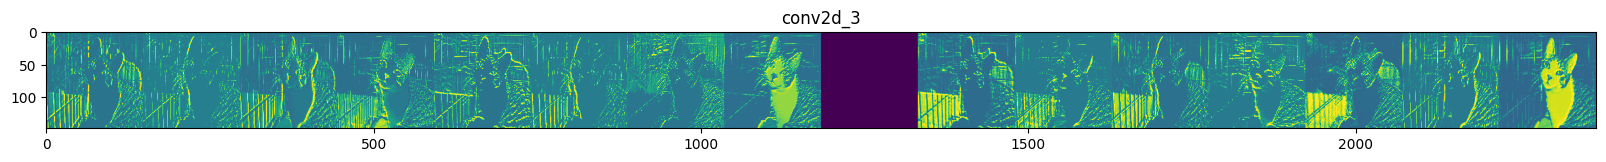

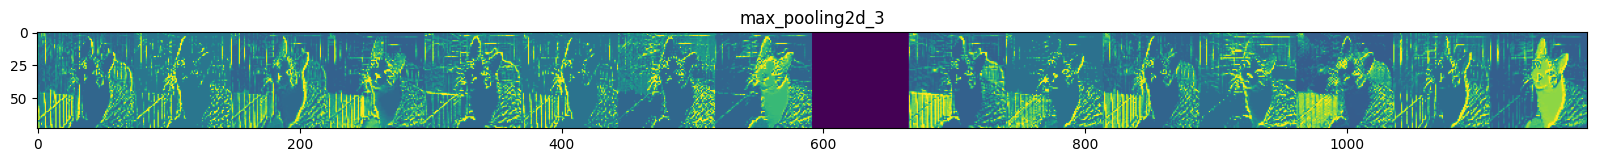

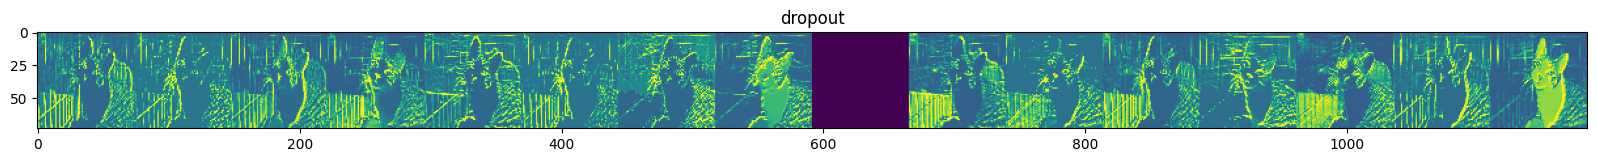

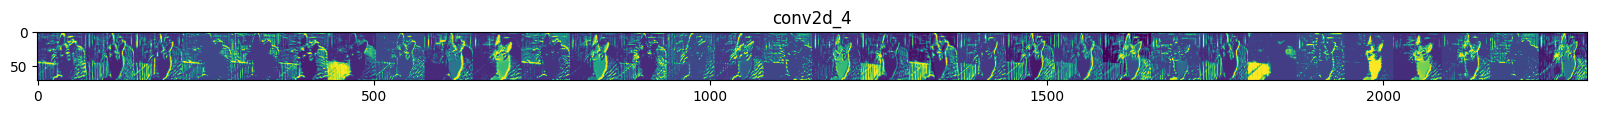

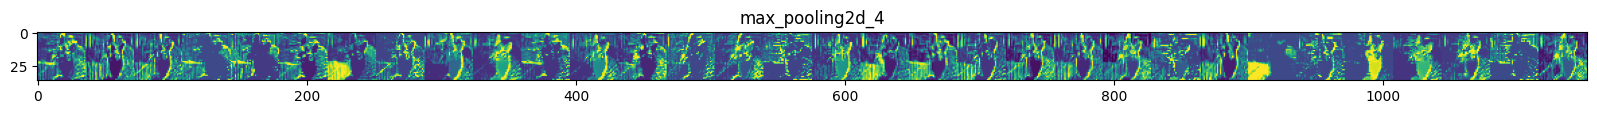

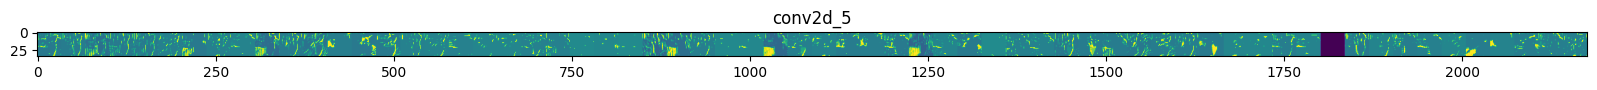

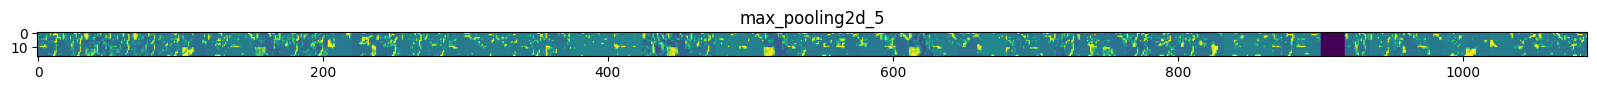

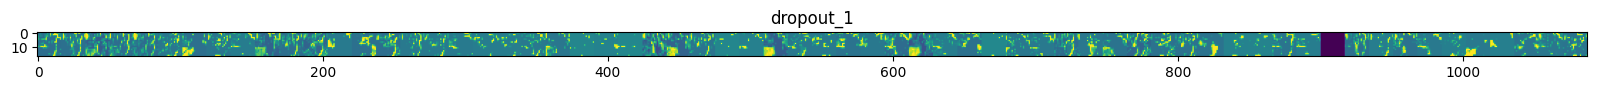

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs=model.input,
                                            outputs=successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1, ) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[
            -1]  # number of features in the feature map
        size = feature_map.shape[
            1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size:(i + 1) *
                         size] = x  # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [ ]:
#uploaded=files.upload()

#for fn in uploaded.keys():
fn = 'dog.2002.jpg'  # change it to your image file
# predicting images
path = 'cats_and_dogs_filtered/validation/dogs/dog.2002.jpg'  # change it to your image
img = image.load_img(path, target_size=(150, 150))

x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)

print(classes[0])

if classes[0] > 0.5:
    print(fn + " is a dog")
else:
    print(fn + " is a cat")


1/1 [==============================] - 0s 107ms/step
[0.9999981]
dog.2002.jpg is a dog


Text(0.5, 1.0, 'Training and validation loss')

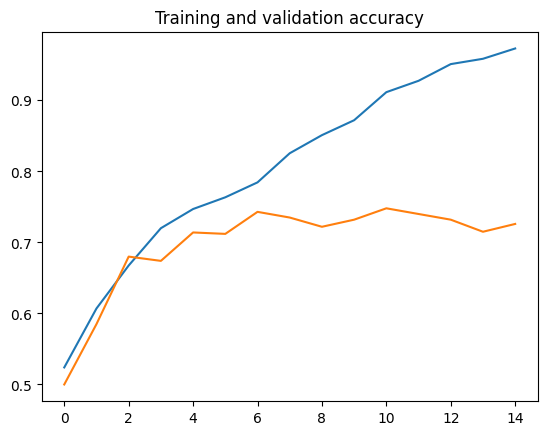

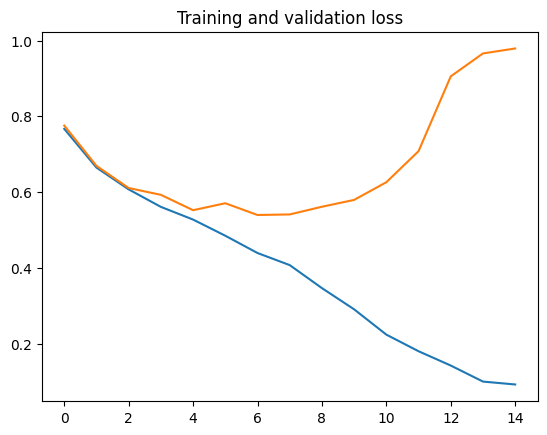

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')


### **Bài tập tự thực hành**

**Resize ảnh và Hồi quy Logistic**

In [ ]:
from PIL import Image
from sklearn.linear_model import LogisticRegression


# Kích thước ảnh sau khi resize
img_size = (150, 150)

def load_and_resize_images(directory):
  """
  Hàm load và resize ảnh từ thư mục
  """
  images = []
  labels = []
  for filename in os.listdir(directory):
    # Load ảnh và resize
    img = Image.open(os.path.join(directory, filename)).resize(img_size)
    # Chuyển đổi ảnh thành mảng numpy
    img_array = np.array(img)
    images.append(img_array)
    # Gán nhãn
    label = 1 if "dog" in filename else 0
    labels.append(label)
  return np.array(images), np.array(labels)

# Load và resize ảnh
X_cat, y_cat = load_and_resize_images(train_cats_dir)
X_dog, y_dog = load_and_resize_images(train_dogs_dir)

# Kết hợp dữ liệu
X = np.concatenate((X_cat, X_dog))
y = np.concatenate((y_cat, y_dog))

# Flatten ảnh thành vector
X = X.reshape(X.shape[0], -1)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Huấn luyện mô hình Hồi quy Logistic
model = LogisticRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.54


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sử dụng PCA và ANN**

In [ ]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Giảm số chiều bằng PCA
pca = PCA(n_components=225)
X_pca = pca.fit_transform(X)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

# Xây dựng mô hình ANN
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(225,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile mô hình
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10)

# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Epoch 1/10
50/50 [==============================] - 1s 3ms/step - loss: 155.4974 - accuracy: 0.5100
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 43.2122 - accuracy: 0.7256
Epoch 3/10
50/50 [==============================] - 0s 3ms/step - loss: 22.1205 - accuracy: 0.8125
Epoch 4/10
50/50 [==============================] - 0s 3ms/step - loss: 8.5482 - accuracy: 0.8956
Epoch 5/10
50/50 [==============================] - 0s 3ms/step - loss: 3.0369 - accuracy: 0.9469
Epoch 6/10
50/50 [==============================] - 0s 3ms/step - loss: 2.2725 - accuracy: 0.9519
Epoch 7/10
50/50 [==============================] - 0s 3ms/step - loss: 1.7019 - accuracy: 0.9675
Epoch 8/10
50/50 [==============================] - 0s 3ms/step - loss: 1.4680 - accuracy: 0.9694
Epoch 9/10
50/50 [==============================] - 0s 3ms/step - loss: 0.8611 - accuracy: 0.9806
Epoch 10/10
13/13 [==============================] - 0s 2ms/step
Accuracy: 0.555


### Ví dụ 2. Phân loại ảnh Chó – Mèo – Gấu trúc bằng CNN sử dụng thư viện Keras TensorFlow.

In [ ]:
!pip install -q gdown

In [ ]:
import gdown

file_id ='11pV5VL2yfq6h9hEoVF7x1mlgaEHsiMBS'

output_path = 'CNN_MultiClass_data.zip'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False,fuzzy=True)

!unzip -q CNN_MultiClass_data.zip

Downloading...
From (original): https://drive.google.com/uc?id=11pV5VL2yfq6h9hEoVF7x1mlgaEHsiMBS
From (redirected): https://drive.google.com/uc?id=11pV5VL2yfq6h9hEoVF7x1mlgaEHsiMBS&confirm=t&uuid=86e5a7d0-b82a-40a1-825b-18703d090bc9
To: /content/CNN_MultiClass_data.zip
100%|██████████| 396M/396M [00:03<00:00, 130MB/s]


In [ ]:
# Trains a model to classify images of 3 classes: cat, dog, and panda
def gen_model():

    # Defines & compiles the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3),
                               activation='relu',
                               input_shape=(150, 150, 3)),
                               tf.keras.layers.MaxPooling2D(2, 2),
                               keras.layers.Dropout(
                               rate=0.15
                                ),  #adding dropout regularization throughout the model to deal with overfitting
        # The second convolution
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(rate=0.1),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(rate=0.10),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),

        # 3 output neuron for the 3 classes of Animal Images
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])
    return model

In [ ]:
# Trains a model to classify images of 3 classes: cat, dog, and panda
def train_test_animals():
    # Creates an instance of an ImageDataGenerator called train_datagen, and a train_generator, train_datagen.flow_from_directory


    #splits data into training and testing(validation) sets
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    #training data
    train_generator = train_datagen.flow_from_directory(
        'CNN_MultiClass_data/animals',
        # Source directory
        target_size=(150, 150),  # Resizes images
        batch_size=15,
        class_mode='categorical',
        subset='training')
    epochs = 2

    #Testing data
    validation_generator = train_datagen.flow_from_directory(
        'CNN_MultiClass_data/validation',
        target_size=(150, 150),
        batch_size=15,
        class_mode='categorical',
        subset='validation')  # set as validation data
    model = gen_model()
    #Model fitting for a number of epochs
    history = model.fit(train_generator,
                                  steps_per_epoch=150,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  validation_steps=50,
                                  verbose=1)

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #This code is used to plot the training and validation accuracy
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # returns accuracy of training
    print("Training Accuracy:", history.history['acc'][-1])
    print("Testing Accuracy:", history.history['val_acc'][-1])


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/2
150/150 [==============================] - 18s 97ms/step - loss: 0.9590 - acc: 0.5471 - val_loss: 0.8020 - val_acc: 0.6027
Epoch 2/2
150/150 [==============================] - 19s 129ms/step - loss: 0.7078 - acc: 0.6551 - val_loss: 0.7202 - val_acc: 0.6520


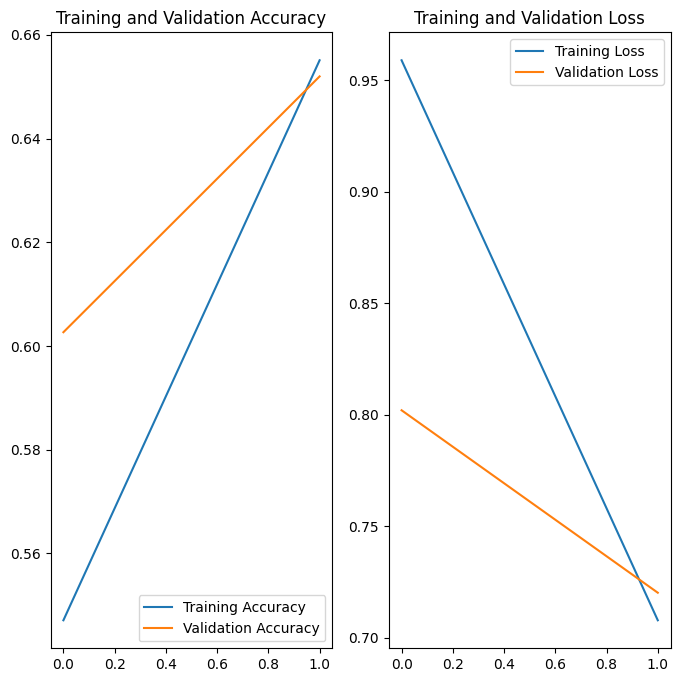

Training Accuracy: 0.6551111340522766
Testing Accuracy: 0.6520000100135803


In [ ]:
train_test_animals()

### **Bài tập tự thực hành**

**Resize ảnh và sử dụng Hồi quy Softmax**

In [ ]:
base_dir = 'CNN_MultiClass_data'
# Change the base_dir to where you put dataset
print("Contents of base directory:")
print(os.listdir(base_dir))

train_dir = os.path.join(base_dir, 'animals')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_panda_dir = os.path.join(train_dir, 'panda')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_panda_dir = os.path.join(validation_dir, 'panda')

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/animals'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'animals']

Contents of train directory:
['panda', 'dogs', 'cats']

Contents of validation directory:
['panda', 'dogs', 'cats']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
# Chuyển ảnh thành vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding nhãn
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Xây dựng mô hình
model = Sequential()
model.add(Dense(3, activation='softmax'))

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (1000, 150, 150) + inhomogeneous part.

In [ ]:
from sklearn.decomposition import PCA

# Giảm số chiều bằng PCA
pca = PCA(n_components=225)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Xây dựng mô hình ANN
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train_pca, y_train, epochs=10, batch_size=32)

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test_pca, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Xây dựng mô hình CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)